In [83]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from argparse import Namespace

from sklearn import metrics
from sklearn.model_selection import train_test_split

from datasetPreProcessing import LoadDatasetByName
from datasetPreProcessing import LoadFeatureByName
from models import *
from methods import *

import functools
import numpy as np
import pandas as pd
import torch
import scipy
#import os
import time

import pyod

from pyod.models.base import BaseDetector
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.suod import SUOD
from pyod.models.xgbod import XGBOD

from pyod.models.alad import ALAD
from pyod.models.abod import ABOD
from pyod.models.lof import LOF
from pyod.models.cblof import CBLOF
from pyod.models.cof import COF

from pyod.models.hbos import HBOS
from pyod.models.copod import COPOD
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.loda import LODA

from pyod.models.mcd import MCD
from pyod.models.pca import PCA
from pyod.models.ocsvm import OCSVM
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.kpca import KPCA

# distribution based OD
from pyod.models.kde import KDE

from pyod.models.anogan import AnoGAN

from pyod.models.auto_encoder import AutoEncoder as pyodAE
from pyod.models.vae import VAE as pyodVAE
from models import AE_pyod

# supervised OD
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
# import data
#DATASET = 'ECU_IoHT_data'
DATASET = 'ECU_IoHT_data_t'
#DATASET = 'TON_IoT_data'
DATASET = 'TON_IoT_full_data'
#DATASET = 'TON_IoT_full_data_t'
DATASET = 'creditcard_data'
#DATASET = 'full_data'
#DATASET = 'network_data_h'
#DATASET = 'iiot_data'
#DATASET = 'iiot_data_h'
#DATASET = 'network_data_h'
#DATASET = 'KDD_10'
hardClassify = True

unbalanced_data = True
CONTAMINATION = 0.01
"""___________________Hyper Parameters________________________"""
repetitions = 1

"""___________________________________________________________"""
# Load Dataset
raw_data, anomalous_raw, features, categorical_data_index = LoadDatasetByName(DATASET)
print(raw_data.shape, anomalous_raw.shape)
# Pre-process data
trim_data = False 
filter_corrcoef = True
normalize_data = True
normalization_scheme = "standard_scaling"
remove_noise = False 
noise_threshold = 5
return_dict = {}
SPLIT = [0.9, 0.05, 0.05]
train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_raw, trim=trim_data, split=SPLIT, trim_threshold=0.98, normalize=normalize_data, normalization_scheme=normalization_scheme,
            filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold, return_dict=return_dict, discretize=False, categorical_data_index=categorical_data_index)
print("Train data shape: {}; anomalous data shape: {}".format(train_data.shape, anomalous_data.shape))
# 
specificity_list, recall_list = [], []

(284315, 29) (492, 29)
Train data shape after trim:  (255883, 29)
Train data shape after filter corrcoef:  (255883, 29)
Normalization scheme:  standard_scaling
Train data shape after normalize:  (255883, 29)
Train data shape: (255883, 29); anomalous data shape: (492, 29)


In [85]:
# list of OD models training on data with both normal data and anomalies
unsupervised_ODs = []
RF = RandomForestClassifier(class_weight='balanced')
HistGB = HistGradientBoostingClassifier(class_weight='balanced')
LR = LogisticRegression(class_weight='balanced')
params_AE = {
    "contamination":CONTAMINATION, "output_activation":'relu', "dropout_rate":0., "l2_regularizer":0e-7, "preprocessing":False,'hidden_neurons':[64, 16, 16, 16, 16, 64],
}

supervised_ODs = [
                    # distribution based algorithms
                    (RF, 'RF'),
                    (HistGB, 'HistGB'),
                    (LR, 'LR')
                    #(ABOD(contamination=0.1, n_neighbors=5), 'ABOD'),   
]
model_list = [
                        #pyodAE(**params_AE),
                        HBOS(contamination=CONTAMINATION),
                        #COPOD(contamination=CONTAMINATION),
                        #LOF(contamination=CONTAMINATION),
                        #KNN(contamination=CONTAMINATION),
                        #
                        #IForest(contamination=CONTAMINATION),
                        
                        # reconstruction/projection based algorithms
                        #PCA(contamination=CONTAMINATION),
                        #DeepSVDD(contamination=CONTAMINATION),
                        #MCD(contamination=CONTAMINATION),
]
# list of OD models training on data with only normal data
semi_supervised_ODs = [
                        (OCSVM(contamination=CONTAMINATION, kernel='linear'), 'OCSVM'),
                        (KPCA(contamination=CONTAMINATION, kernel='linear'), 'KPCA'),
                    ]
distribution_based_ODs = [
                        (HBOS(contamination=CONTAMINATION), 'HBOS'),
                        (COPOD(contamination=CONTAMINATION), 'COPOD'),
                        (MCD(contamination=CONTAMINATION), 'MCD'),
                    ]
density_based_ODs = [
                        (LOF(contamination=CONTAMINATION), 'LOF'),
                        (KNN(contamination=CONTAMINATION, n_neighbors=5, method='median'), 'KNN'),
                        (IForest(contamination=CONTAMINATION), 'IForest'),
                    ]
projection_based_ODs = [
                        (PCA(contamination=CONTAMINATION), 'PCA'),
                        (KPCA(contamination=CONTAMINATION), 'KPCA'),
                        (DeepSVDD(contamination=CONTAMINATION), 'DSVDD'),
                        (OCSVM(contamination=CONTAMINATION, kernel='poly'), 'OCSVM'),
                    ]
# 
best_ODs = [
                        (PCA(contamination=CONTAMINATION), 'PCA'),
                        (MCD(contamination=CONTAMINATION), 'MCD'),
                        (KNN(contamination=CONTAMINATION, n_neighbors=5, method='median'), 'KNN'),
                        #(KPCA(contamination=CONTAMINATION), 'KPCA'),
                        #(DeepSVDD(contamination=CONTAMINATION), 'DSVDD'),
                        #(OCSVM(contamination=CONTAMINATION), 'One-Class-SVM'),
                    ]
# list of OD models training on data with only normal data
all_ODs = [
                        # distribution based algorithms
                        (HBOS(contamination=CONTAMINATION), 'HBOS'),
                        (COPOD(contamination=CONTAMINATION), 'COPOD'),
                        #(MCD(contamination=CONTAMINATION), 'MCD'),
                        # proximity/density based algorithms
                        (LOF(contamination=CONTAMINATION), 'LOF'),
                        (KNN(contamination=CONTAMINATION, n_neighbors=5, method='median'), 'KNN'),
                        (IForest(contamination=CONTAMINATION), 'IForest'),
                        # reconstruction/projection based algorithms
                        (PCA(contamination=CONTAMINATION), 'PCA'),
                        #(DeepSVDD(contamination=CONTAMINATION), 'DSVDD'),
                        #(OCSVM(contamination=CONTAMINATION, kernel='poly'), 'OCSVM'),
                        #(KPCA(contamination=CONTAMINATION, kernel='poly'), 'KPCA'),
                    ]

""" semi_supervised_ODs = [
                        #(pyodAE(contamination=CONTAMINATION,hidden_neurons=[128, 64, 4, 4, 64, 128], output_activation='relu', dropout_rate=0., l2_regularizer=0e-7, preprocessing=False), 'pyodAE'),
                        #(FeatureBagging(base_estimator=pyodAE(), n_estimators=2, contamination=CONTAMINATION, max_features=1.0, combination='max',estimator_params=params_AE), 'FeatureBagging'),
                        #(FeatureBagging(base_estimator=pyodVAE(contamination=0.01), n_estimators=2, contamination=0.1, max_features=1.0, combination='average',estimator_params={'encoder_neurons':[128, 64, 4],'decoder_neurons':[4, 64, 128],}), 'FeatureBagging'),
                        (FeatureBagging(base_estimator=DeepSVDD(contamination=0.05), n_estimators=5, contamination=0.1, max_features=1.0, combination='max'), 'FeatureBagging'),
                        #(SUOD(base_estimators=model_list), 'SUOD'),
                        #(XGBOD(estimator_list=model_list), 'XGBOD'),
                    ] """

" semi_supervised_ODs = [\n                        #(pyodAE(contamination=CONTAMINATION,hidden_neurons=[128, 64, 4, 4, 64, 128], output_activation='relu', dropout_rate=0., l2_regularizer=0e-7, preprocessing=False), 'pyodAE'),\n                        #(FeatureBagging(base_estimator=pyodAE(), n_estimators=2, contamination=CONTAMINATION, max_features=1.0, combination='max',estimator_params=params_AE), 'FeatureBagging'),\n                        #(FeatureBagging(base_estimator=pyodVAE(contamination=0.01), n_estimators=2, contamination=0.1, max_features=1.0, combination='average',estimator_params={'encoder_neurons':[128, 64, 4],'decoder_neurons':[4, 64, 128],}), 'FeatureBagging'),\n                        (FeatureBagging(base_estimator=DeepSVDD(contamination=0.05), n_estimators=5, contamination=0.1, max_features=1.0, combination='max'), 'FeatureBagging'),\n                        #(SUOD(base_estimators=model_list), 'SUOD'),\n                        #(XGBOD(estimator_list=model_list), 'XGBO

In [86]:
pr_dict, roc_dict, mcc_dict = {}, {}, {} # dictionaries of all models' performances to plot
train_time_dict, inference_time_dict = {}, {} # dictionaries of all models' CPU time costs
spec_sens_dict = {}

In [87]:
# pipeline
# train and test data
if unbalanced_data:
    X_train, y_train = train_data, np.zeros(train_data.shape[0])
    X_test = np.concatenate((validation_data, test_data, anomalous_data), axis=0)
    y_test = np.concatenate((np.zeros(validation_data.shape[0]+test_data.shape[0]), np.ones(anomalous_data.shape[0])), axis=0) 
else: # if data is balanced
    X = np.concatenate((train_data, validation_data, test_data, anomalous_data), axis=0)
    Y = np.concatenate((np.zeros(raw_data.shape[0]), np.ones(anomalous_data.shape[0])), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=False) 

ODs = all_ODs

for clf, clf_name in ODs: # loop over all algorithms
    # create prediction (probability) list to compute average upon
    predictions=[]
    
    train_time, inference_time = 0, 0
    for _ in range(repetitions): # r repetitions
        curr_time = time.time() # record train and test CPU time cost
        clf.fit(X_train, y_train) # fit
        train_time += time.time()-curr_time
        
        # test
        curr_time = time.time()
        if hardClassify:
            #y_pred = clf.predict(X_test)
            #y_pred = clf.predict_proba(X_test)
            #y_pred = y_pred[:,-1]
            y_pred = clf.decision_function(X_test)
        else:
            #y_pred = clf.decision_function(X_test)
            print(X_test.shape)
            y_pred = clf.predict_proba(X_test)
            y_pred = y_pred[:,-1]
        #y_pred = np.nan_to_num(y_pred, nan=1e30)
        inference_time += time.time()-curr_time
        predictions.append(y_pred)
    
    # show average time consumption
    train_time, inference_time = train_time/repetitions, inference_time/repetitions
    print("Train time of {}: {:.4f} seconds.".format(clf_name, train_time))
    print("Inference time of {}: {:.4f} seconds.".format(clf_name, inference_time))
    # compute average predictions
    y_pred_average = functools.reduce(lambda a, b: a+b, predictions) / repetitions
    
    precision, recall, _ = metrics.precision_recall_curve(y_true=y_test, probas_pred=y_pred_average)
    fpr, tpr, thresholds = metrics.roc_curve(y_true=y_test, y_score=y_pred_average)
    #fpr, tpr, thresholds = fpr[1:-1], tpr[1:-1], thresholds[1:-1]
    #fpr, tpr, thresholds = fpr, tpr, thresholds
    #thresholds = (thresholds - thresholds.min())/(thresholds.max() - thresholds.min())   # scale thresholds to (0, 1)
    mcc = MCC(specificity=1-fpr, sensitivity=tpr)
    """ if hardClassify:
        specificity, sensitivity = metrics.recall_score(y_true=y_test, y_pred=y_pred_average, pos_label=0), metrics.recall_score(y_true=y_test, y_pred=y_pred_average)
        spec_sens_dict[clf_name] = (specificity, sensitivity) """
        
    pr_dict[clf_name] = (recall, precision)
    roc_dict[clf_name] = (fpr, tpr)
    mcc_dict[clf_name] = (thresholds, mcc)
    train_time_dict[clf_name] = train_time
    inference_time_dict[clf_name] = inference_time



Train time of HBOS: 1.8595 seconds.
Inference time of HBOS: 0.0173 seconds.
Train time of COPOD: 2.0459 seconds.
Inference time of COPOD: 2.3781 seconds.
Train time of LOF: 42.4650 seconds.
Inference time of LOF: 4.6285 seconds.
Train time of KNN: 41.2873 seconds.
Inference time of KNN: 344.1892 seconds.
Train time of IForest: 7.3457 seconds.
Inference time of IForest: 0.4212 seconds.
Train time of PCA: 0.4269 seconds.
Inference time of PCA: 0.0228 seconds.


In [88]:
# train supervised ODs
X = np.concatenate((train_data, validation_data, test_data), axis=0)
Y = np.zeros(X.shape[0])
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, Y, train_size=0.9, shuffle=False)

X = anomalous_data
Y = np.ones(anomalous_data.shape[0])
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, Y, train_size=0.9, shuffle=False)

X_train, X_test, y_train, y_test = np.concatenate((X_train1, X_train2), axis=0), np.concatenate((X_test1, X_test2), axis=0), np.concatenate((y_train1, y_train2), axis=0), np.concatenate((y_test1, y_test2), axis=0)

for clf, clf_name in supervised_ODs:
    # create prediction (probability) list to compute average upon
    predictions=[]
    
    train_time, inference_time = 0, 0
    for _ in range(repetitions):
        curr_time = time.time() # record train and test CPU time cost
        clf.fit(X_train, y_train)
        train_time += time.time()-curr_time
        # test
        curr_time = time.time()
        if False:
            #y_pred = clf.predict(X_test)
            #y_pred = clf.predict_proba(X_test)
            #y_pred = y_pred[:,-1]
            y_pred = clf.decision_function(X_test)
        else:
            #y_pred = clf.decision_function(X_test)
            y_pred = clf.predict_proba(X_test)
            y_pred = y_pred[:,-1]
        #y_pred = np.nan_to_num(y_pred, nan=1e30)
        inference_time += time.time()-curr_time
        predictions.append(y_pred)
    
    # show average time consumption
    train_time, inference_time = train_time/repetitions, inference_time/repetitions
    print("Train time of {}: {:.4f} seconds.".format(clf_name, train_time))
    print("Inference time of {}: {:.4f} seconds.".format(clf_name, inference_time))
    # compute average predictions
    y_pred_average = functools.reduce(lambda a, b: a+b, predictions) / repetitions
    
    precision, recall, _ = metrics.precision_recall_curve(y_true=y_test, probas_pred=y_pred_average)
    fpr, tpr, thresholds = metrics.roc_curve(y_true=y_test, y_score=y_pred_average)
    fpr, tpr, thresholds = fpr, tpr, thresholds
    #mcc = MCC(specificity=1-fpr, sensitivity=tpr)
        
    pr_dict[clf_name] = (recall, precision)
    roc_dict[clf_name] = (fpr, tpr)
    mcc_dict[clf_name] = (thresholds, mcc)
    train_time_dict[clf_name] = train_time
    inference_time_dict[clf_name] = inference_time

Train time of RF: 83.5722 seconds.
Inference time of RF: 0.1073 seconds.
Train time of HistGB: 1.5291 seconds.
Inference time of HistGB: 0.0119 seconds.
Train time of LR: 1.1199 seconds.
Inference time of LR: 0.0016 seconds.


In [90]:
transfer = False
suffix = ''
latent_dim, hidden_dim=16, 32
# import trained AE model and evaluate
from models import AutoEncoder
from models import SVAE

X_train, y_train = train_data, np.zeros(train_data.shape[0])
X_test = np.concatenate((validation_data, test_data, anomalous_data), axis=0)
y_test = np.concatenate((np.zeros(validation_data.shape[0]+test_data.shape[0]), np.ones(anomalous_data.shape[0])), axis=0)
if transfer:
    raw_data, anomalous_raw, features, categorical_data_index = LoadDatasetByName('iiot_data_h')
    X_test, y_test = np.concatenate((raw_data, anomalous_raw), axis=0), np.concatenate((np.zeros(raw_data.shape[0]), np.ones(anomalous_raw.shape[0])), axis=0)

models = [
        AutoEncoder(num_feature=X_test.shape[-1], latent_dim=latent_dim, hidden_dim=hidden_dim, activation="leaky_relu"),
        #DAE(num_feature=X_test.shape[-1], latent_dim=latent_dim, hidden_dim=hidden_dim, activation="leaky_relu"),
        #VAE(num_feature=X_test.shape[-1], latent_dim=latent_dim, hidden_dim=hidden_dim, activation="leaky_relu", sigma=1e-1),
    ]

for model in models:
    model.load_state_dict(torch.load('../model/param_'+model.name+'_'+DATASET+suffix))

    # standard for AE is the train average reconstruction loss
    X_temp = torch.tensor(X_train).to(torch.float)
    standard = ((model(X_temp) - X_temp)**2).detach().numpy()
    mu, sig = np.mean(np.sum(standard, axis=-1)), np.std(np.sum(standard, axis=-1), axis=0)
    # infer
    X_temp = torch.tensor(X_test).to(torch.float)
    curr_time = time.time()
    y_pred = model(X_temp)
    # process predictions
    y_pred = ((y_pred - X_temp)**2).detach().numpy()
    y_pred = np.sum(y_pred, axis=-1)
    #y_pred = np.maximum(0, scipy.special.erf((y_pred-mu)/(2**0.5 * sig)))
    #y_pred = 1 / (1 + np.exp(-y_pred + mu))
    inference_time = time.time() - curr_time
    print("Inference time of {}: {:.4f} seconds.".format(model.name, inference_time)) # inference time
    # metrics
    precision, recall, _ = metrics.precision_recall_curve(y_true=y_test, probas_pred=y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true=y_test, y_score=y_pred)
    #fpr, tpr, thresholds = fpr[1:-1], tpr[1:-1], thresholds[1:-1]
    fpr, tpr, thresholds = fpr, tpr, thresholds
    mcc = MCC(specificity=1-fpr, sensitivity=tpr)
    # add metrics to dict
    pr_dict[model.name] = (recall, precision)
    roc_dict[model.name] = (fpr, tpr)
    thresholds = (thresholds - thresholds.min())/(thresholds.max() - thresholds.min())   # scale thresholds to (0, 1)
    mcc_dict[model.name] = (thresholds, mcc)
    # time
    train_time_dict[model.name] = 146.7071
    inference_time_dict[model.name] = inference_time


Inference time of AE: 0.0598 seconds.


In [91]:
# get hard classification result in AEs
contaminations=[0.01, 0.05]
for model, contamination in itertools.product(models, contaminations):
    temp = torch.tensor(train_data).to(torch.float)
    train_loss = torch.sum((model(temp)-temp)**2, dim=1)
    sorted_loss, _ = torch.sort(train_loss)
    threshold_upper = sorted_loss[math.floor(len(sorted_loss)*(1-contamination))]
    temp = torch.tensor(X_test).to(torch.float)
    score = torch.sum((model(temp)-temp)**2, dim=1)
    score = score > threshold_upper
    score = score.detach().numpy()
    precision, recall, f1 = metrics.precision_score(y_test, score), metrics.recall_score(y_test, score), metrics.f1_score(y_test, score)
    mcc_score = metrics.matthews_corrcoef(y_test, score)
    print("{}\nPrecision: {:.4f}; Recall: {:.4f}; F-1 score: {:.4f}; MCC: {:.4f} at threshold {}".format(model.name, precision, recall, f1, mcc_score, contamination))

AE
Precision: 0.5851; Recall: 0.8313; F-1 score: 0.6868; MCC: 0.6914 at threshold 0.01
AE
Precision: 0.2347; Recall: 0.8638; F-1 score: 0.3691; MCC: 0.4350 at threshold 0.05


In [ ]:
transfer=False
if transfer:
    raw_data, anomalous_raw, features, categorical_data_index = LoadDatasetByName('iiot_data_h')
    X_test, y_test = np.concatenate((raw_data, anomalous_raw), axis=0), np.concatenate((np.zeros(raw_data.shape[0]), np.ones(anomalous_raw.shape[0])), axis=0)

# get hard classification result
contamination = 0.01
for clf, clf_name in all_ODs:
    #clf.set_params(contamination=contamination)
    #clf._process_decision_scores() # update thresholds on contamination
    score = clf.predict(X_test)
    precision, recall, f1 = metrics.precision_score(y_test, score), metrics.recall_score(y_test, score), metrics.f1_score(y_test, score)
    mcc_score = metrics.matthews_corrcoef(y_test, score)
    print("{}\nPrecision: {:.4f}; Recall: {:.4f}; F-1 score: {:.4f}; MCC: {:.4f} at threshold {}".format(clf_name, precision, recall, f1, mcc_score, contamination))

# get hard classification result (different threshold)
contamination = 0.05
for clf, clf_name in all_ODs:
    clf.set_params(contamination=contamination)
    clf._process_decision_scores() # update thresholds on contamination
    score = clf.predict(X_test)
    precision, recall, f1 = metrics.precision_score(y_test, score), metrics.recall_score(y_test, score), metrics.f1_score(y_test, score)
    mcc_score = metrics.matthews_corrcoef(y_test, score)
    print("{}\nPrecision: {:.4f}; Recall: {:.4f}; F-1 score: {:.4f}; MCC: {:.4f} at threshold {}".format(clf_name, precision, recall, f1, mcc_score, contamination))

# get hard classification result in supervised models
for clf, clf_name in supervised_ODs:
    """ train_loss = clf.decision_function(X_test)
    sorted_train_score = np.sort(train_loss)
    threshold_upper = sorted_train_score[math.floor(sorted_train_score.shape[0]*(1-contamination))]
    score = clf.decision_function(X_test) > threshold_upper """
    score = clf.predict(X_test)
    precision, recall, f1 = metrics.precision_score(y_test, score), metrics.recall_score(y_test, score), metrics.f1_score(y_test, score)
    mcc_score = metrics.matthews_corrcoef(y_test, score)
    print("{}\nPrecision: {:.4f}; Recall: {:.4f}; F-1 score: {:.4f}; MCC: {:.4f} at threshold {}".format(clf_name, precision, recall, f1, mcc_score, contamination))

NameError: name 'all_ODs' is not defined

In [92]:
dis = ['HBOS', 'COPOD', 
       #'MCD'
       ]
den = ['KNN', 'LOF', 'IForest']
pro = ['PCA'
       #, 'DSVDD', 'OCSVM'
       ]

best = ['MCD', 'KNN', 'PCA', 'AE']
supervised = ['RF', 'HistGB', 'LR']
aes = [
       #'DAE', 
       #'VAE', 
       'AE']
all = dis + den + pro + supervised + aes
#all = dis + den + pro + supervised
#{x:pr_dict[x] for x in dis}
""" train_time_dict.pop('LR')
train_time_dict.pop('RF')
train_time_dict.pop('HistGB')
inference_time_dict.pop('LR')
inference_time_dict.pop('RF')
inference_time_dict.pop('HistGB') """

" train_time_dict.pop('LR')\ntrain_time_dict.pop('RF')\ntrain_time_dict.pop('HistGB')\ninference_time_dict.pop('LR')\ninference_time_dict.pop('RF')\ninference_time_dict.pop('HistGB') "

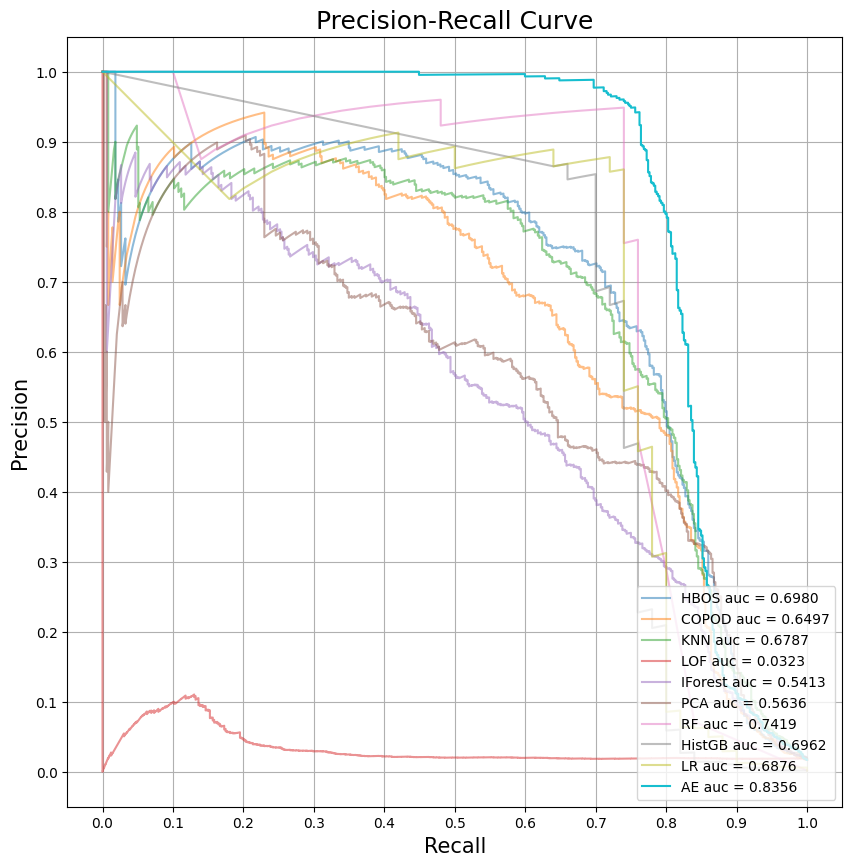

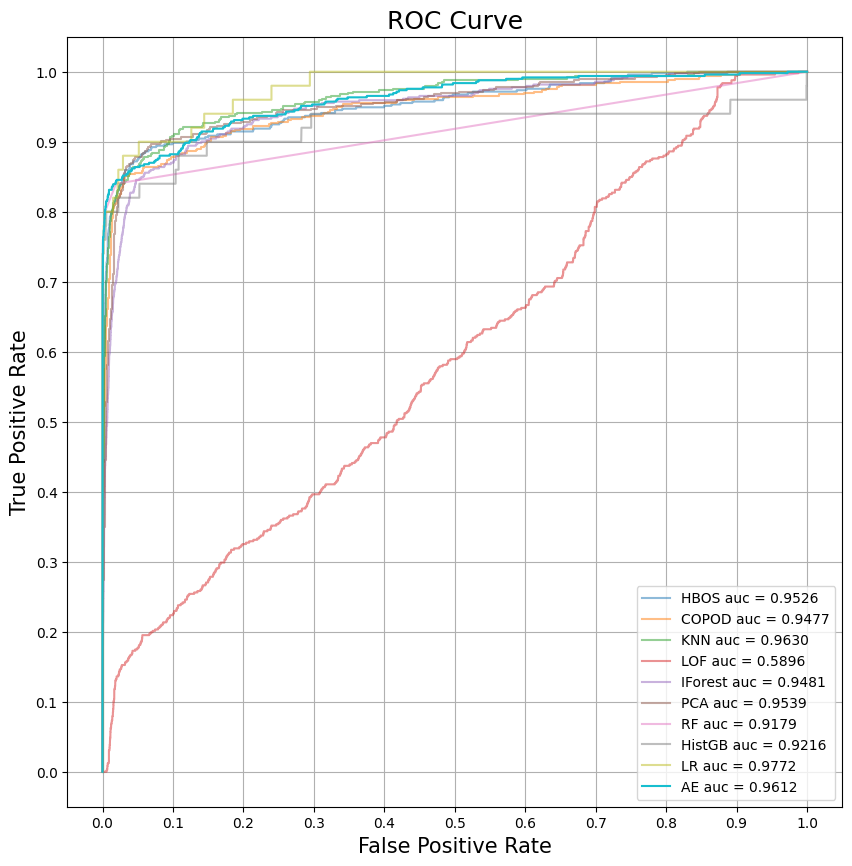

In [94]:
SAVE = False
if DATASET == 'medical_data' or DATASET == 'network_data' or DATASET == 'full_data':
    prefix = 'EHMS '
else:
    prefix = ''
highlight = True

visualize_curve({x:pr_dict[x] for x in all}, x_label="Recall", y_label="Precision", title="Precision-Recall Curve"#+prefix+DATASET
                , save=SAVE, highlight=highlight) 
visualize_curve({x:roc_dict[x] for x in all}, x_label="False Positive Rate", y_label="True Positive Rate", title="ROC Curve"#+prefix+DATASET
                , save=SAVE, highlight=highlight)
                
#visualize_curve(mcc_dict, x_label="Thresholds", y_label="MCC", title="MCC-Threshold Curve - "+prefix+DATASET, save=SAVE) # visualize MCC
#visualize_bar(train_time_dict, save=SAVE, title='Training Time - '+prefix+DATASET, highlight=highlight) # visualize training time
#visualize_bar(inference_time_dict, save=SAVE, title='Inference Time - '+prefix+DATASET, highlight=highlight) # visualize inference time

In [ ]:
# AE train time
# EHMS-full: 57.1001 seconds. 3000 epochs. 
# medical: 56.3706 seconds. 2000 epochs. 
# TON full: 940.6104 seconds. 1000 epochs.
# iiot: 207.1402 seconds. 100 epochs.
# ECU IoHT: 40.4278 seconds. 1000 epochs.
# KDD_99: 608.4025 seconds. 3000 epochs.
# ToN_IoT_full_data: 917.4541 seconds. 2000 epochs.

EHMS-full:
    Train time of HBOS: 0.0076 seconds.
    Inference time of HBOS: 0.0007 seconds.
    Train time of COPOD: 0.0478 seconds.
    Inference time of COPOD: 0.0348 seconds.
    Train time of MCD: 0.4102 seconds.
    Inference time of MCD: 0.0012 seconds.
    Train time of LOF: 0.0956 seconds.
    Inference time of LOF: 0.0590 seconds.
    Train time of KNN: 0.1726 seconds.
    Inference time of KNN: 0.4311 seconds.
    Train time of IForest: 0.3752 seconds.
    Inference time of IForest: 0.0552 seconds.
    Train time of PCA: 0.0069 seconds.
    Inference time of PCA: 0.0006 seconds.
    Train time of DSVDD: 16.3009 seconds.
    Inference time of DSVDD: 0.0665 seconds.
    Train time of OCSVM: 2.7983 seconds.
    Inference time of OCSVM: 0.1953 seconds.
        
    HBOS
    Precision: 0.6364; Recall: 0.0205; F-1 score: 0.0398; MCC: 0.0487 at threshold 0.01
    COPOD
    Precision: 0.9605; Recall: 0.1427; F-1 score: 0.2485; MCC: 0.2790 at threshold 0.01
    MCD
    Precision: 0.9801; Recall: 0.4809; F-1 score: 0.6452; MCC: 0.5732 at threshold 0.01
    LOF
    Precision: 0.9751; Recall: 0.4213; F-1 score: 0.5884; MCC: 0.5246 at threshold 0.01
    KNN
    Precision: 0.9576; Recall: 0.2209; F-1 score: 0.3590; MCC: 0.3525 at threshold 0.01
    IForest
    Precision: 0.9763; Recall: 0.4829; F-1 score: 0.6462; MCC: 0.5721 at threshold 0.01
    PCA
    Precision: 0.7429; Recall: 0.0254; F-1 score: 0.0491; MCC: 0.0765 at threshold 0.01
    DSVDD
    Precision: 0.7391; Recall: 0.0332; F-1 score: 0.0636; MCC: 0.0869 at threshold 0.01
    OCSVM
    Precision: 0.7179; Recall: 0.0274; F-1 score: 0.0527; MCC: 0.0743 at threshold 0.01
    
    AE
    Precision: 0.9904; Recall: 0.4516; F-1 score: 0.6203; MCC: 0.4865 at threshold 0.01
    VAE
    Precision: 0.9890; Recall: 0.4394; F-1 score: 0.6085; MCC: 0.4762 at threshold 0.01
    DAE
    Precision: 0.9839; Recall: 0.3578; F-1 score: 0.5247; MCC: 0.4115 at threshold 0.01

    HBOS
    Precision: 0.8194; Recall: 0.1241; F-1 score: 0.2156; MCC: 0.1392 at threshold 0.05
    COPOD
    Precision: 0.9610; Recall: 0.3128; F-1 score: 0.4720; MCC: 0.3605 at threshold 0.05
    MCD
    Precision: 0.9429; Recall: 0.4599; F-1 score: 0.6183; MCC: 0.4471 at threshold 0.05
    LOF
    Precision: 0.9295; Recall: 0.5029; F-1 score: 0.6527; MCC: 0.4630 at threshold 0.05
    KNN
    Precision: 0.9247; Recall: 0.4858; F-1 score: 0.6370; MCC: 0.4463 at threshold 0.05
    IForest
    Precision: 0.9453; Recall: 0.4726; F-1 score: 0.6302; MCC: 0.4583 at threshold 0.05
    PCA
    Precision: 0.9202; Recall: 0.3944; F-1 score: 0.5522; MCC: 0.3814 at threshold 0.05
    DSVDD
    Precision: 0.9352; Recall: 0.4443; F-1 score: 0.6024; MCC: 0.4289 at threshold 0.05
    OCSVM
    Precision: 0.7770; Recall: 0.1022; F-1 score: 0.1806; MCC: 0.1033 at threshold 0.05
    
    AE
    Precision: 0.9493; Recall: 0.5034; F-1 score: 0.6579; MCC: 0.4840 at threshold 0.05
    VAE
    Precision: 0.9517; Recall: 0.5103; F-1 score: 0.6643; MCC: 0.4913 at threshold 0.05
    DAE
    Precision: 0.9373; Recall: 0.4971; F-1 score: 0.6496; MCC: 0.4671 at threshold 0.05

    
    RF
    Precision: 0.9804; Recall: 0.1466; F-1 score: 0.2551; MCC: 0.2905
    HistGB
    Precision: 0.9086; Recall: 0.4663; F-1 score: 0.6163; MCC: 0.5126
    LR
    Precision: 0.6609; Recall: 0.4858; F-1 score: 0.5600; MCC: 0.3135
    


KDD-99:

    Train time of HBOS: 0.0647 seconds.
    Inference time of HBOS: 0.1630 seconds.
    Train time of COPOD: 0.6478 seconds.
    Inference time of COPOD: 1.9085 seconds.
    Train time of MCD: 1462.9882 seconds.
    Inference time of MCD: 0.3148 seconds.
    Train time of LOF: 5.6395 seconds.
    Inference time of LOF: 24.5356 seconds.
    Train time of KNN: 4.8981 seconds.
    Inference time of KNN: 154.6989 seconds.
    Train time of IForest: 2.4683 seconds.
    Inference time of IForest: 4.4446 seconds.
    Train time of PCA: 0.1996 seconds.
    Inference time of PCA: 0.2452 seconds.
    Train time of DSVDD: 110.1787 seconds.
    Inference time of DSVDD: 4.9240 seconds.
    Train time of One-Class-SVM: 434.2055 seconds.
    Inference time of One-Class-SVM: 716.8229 seconds.
    Inference time of AE: 1.2397 seconds.
    Inference time of VAE: 0.7669 seconds.
    Inference time of DAE: 1.0052 seconds.

    HBOS
    Precision: 0.9957; Recall: 0.0598; F-1 score: 0.1127; MCC: 0.0320 at threshold 0.01
    COPOD
    Precision: 0.9632; Recall: 0.0251; F-1 score: 0.0489; MCC: -0.0136 at threshold 0.01
    MCD
    Precision: 0.9947; Recall: 0.0567; F-1 score: 0.1073; MCC: 0.0297 at threshold 0.01
    LOF
    Precision: 0.0206; Recall: 0.0000; F-1 score: 0.0000; MCC: -0.0966 at threshold 0.01
    KNN
    Precision: 0.9998; Recall: 0.9409; F-1 score: 0.9695; MCC: 0.5214 at threshold 0.01
    IForest
    Precision: 0.9991; Recall: 0.2777; F-1 score: 0.4347; MCC: 0.0918 at threshold 0.01
    PCA
    Precision: 0.9998; Recall: 0.9573; F-1 score: 0.9781; MCC: 0.5862 at threshold 0.01
    DSVDD
    Precision: 0.9989; Recall: 0.2259; F-1 score: 0.3684; MCC: 0.0793 at threshold 0.01
    OCSVM
    Precision: 0.9954; Recall: 0.0601; F-1 score: 0.1134; MCC: 0.0316 at threshold 0.01
    
    AE
    Precision: 0.9998; Recall: 0.9964; F-1 score: 0.9981; MCC: 0.9266 at threshold 0.01
    DAE
    Precision: 0.9998; Recall: 0.9895; F-1 score: 0.9946; MCC: 0.8274 at threshold 0.01
    VAE
    Precision: 0.9992; Recall: 0.2884; F-1 score: 0.4476; MCC: 0.0949 at threshold 0.01
    
    HBOS
    Precision: 0.9954; Recall: 0.2778; F-1 score: 0.4343; MCC: 0.0775 at threshold 0.05
    COPOD
    Precision: 0.9572; Recall: 0.0841; F-1 score: 0.1546; MCC: -0.0378 at threshold 0.05
    MCD
    Precision: 0.9786; Recall: 0.0575; F-1 score: 0.1086; MCC: 0.0041 at threshold 0.05
    LOF
    Precision: 0.9982; Recall: 0.7274; F-1 score: 0.8415; MCC: 0.2276 at threshold 0.05
    KNN
    Precision: 0.9988; Recall: 0.9919; F-1 score: 0.9953; MCC: 0.8364 at threshold 0.05
    IForest
    Precision: 0.9988; Recall: 0.9882; F-1 score: 0.9935; MCC: 0.7896 at threshold 0.05
    PCA
    Precision: 0.9987; Recall: 0.9890; F-1 score: 0.9938; MCC: 0.7973 at threshold 0.05
    DSVDD
    Precision: 0.9956; Recall: 0.2757; F-1 score: 0.4318; MCC: 0.0778 at threshold 0.05
    OCSVM
    Precision: 0.9794; Recall: 0.0608; F-1 score: 0.1144; MCC: 0.0055 at threshold 0.05

    AE
    Precision: 0.9988; Recall: 0.9979; F-1 score: 0.9983; MCC: 0.9312 at threshold 0.05
    DAE
    Precision: 0.9989; Recall: 0.9964; F-1 score: 0.9976; MCC: 0.9072 at threshold 0.05
    VAE
    Precision: 0.9988; Recall: 0.9978; F-1 score: 0.9983; MCC: 0.9289 at threshold 0.05
    
    RF
    Precision: 1.0000; Recall: 0.9845; F-1 score: 0.9922; MCC: 0.8649
    HistGB
    Precision: 1.0000; Recall: 0.9985; F-1 score: 0.9993; MCC: 0.9843
    LR
    Precision: 0.9998; Recall: 0.9929; F-1 score: 0.9964; MCC: 0.9293
    

TON-IoT-full:

    Train time of HBOS: 0.2879 seconds.
    Inference time of HBOS: 0.1135 seconds.
    Train time of COPOD: 1.7858 seconds.
    Inference time of COPOD: 3.1599 seconds.
    Train time of MCD: 15.7341 seconds.
    Inference time of MCD: 0.2275 seconds.
    Train time of LOF: 61.2099 seconds.
    Inference time of LOF: 43.0477 seconds.
    Train time of KNN: 58.6569 seconds.
    Inference time of KNN: 1294.1517 seconds.
    Train time of IForest: 8.6385 seconds.
    Inference time of IForest: 3.0234 seconds.
    Train time of PCA: 0.8738 seconds.
    Inference time of PCA: 0.1895 seconds.
    Train time of DSVDD: 326.7423 seconds.
    Inference time of DSVDD: 2.4316 seconds.
    Train time of OCSVM: 2845.7916 seconds.
    Inference time of OCSVM: 565.9433 seconds.

    Inference time of AE: 0.2023 seconds.
    Inference time of DAE: 0.2209 seconds.
    Inference time of VAE: 0.2737 seconds.

    HBOS
    Precision: 0.8095; Recall: 0.0004; F-1 score: 0.0008; MCC: -0.0019 at threshold 0.01
    COPOD
    Precision: 0.8765; Recall: 0.0102; F-1 score: 0.0202; MCC: 0.0092 at threshold 0.01
    MCD
    Precision: 0.8583; Recall: 0.0095; F-1 score: 0.0187; MCC: 0.0041 at threshold 0.01
    LOF
    Precision: 0.9968; Recall: 0.5414; F-1 score: 0.7017; MCC: 0.3886 at threshold 0.01
    KNN
    Precision: 0.9858; Recall: 0.1330; F-1 score: 0.2344; MCC: 0.1406 at threshold 0.01
    IForest
    Precision: 0.7223; Recall: 0.0048; F-1 score: 0.0095; MCC: -0.0248 at threshold 0.01
    PCA
    Precision: 0.9948; Recall: 0.3541; F-1 score: 0.5223; MCC: 0.2732 at threshold 0.01
    DSVDD
    Precision: 0.9948; Recall: 0.3614; F-1 score: 0.5302; MCC: 0.2773 at threshold 0.01
    OCSVM
    Precision: 0.0721; Recall: 0.0001; F-1 score: 0.0003; MCC: -0.0885 at threshold 0.01

    AE
    Precision: 0.9950; Recall: 0.3562; F-1 score: 0.5246; MCC: 0.2746 at threshold 0.01
    DAE
    Precision: 0.9949; Recall: 0.3559; F-1 score: 0.5242; MCC: 0.2744 at threshold 0.01
    VAE
    Precision: 0.9950; Recall: 0.3526; F-1 score: 0.5207; MCC: 0.2727 at threshold 0.01

    
    HBOS
    Precision: 0.8603; Recall: 0.0337; F-1 score: 0.0649; MCC: 0.0088 at threshold 0.05
    COPOD
    Precision: 0.8664; Recall: 0.0651; F-1 score: 0.1212; MCC: 0.0168 at threshold 0.05
    MCD
    Precision: 0.9373; Recall: 0.1370; F-1 score: 0.2391; MCC: 0.0972 at threshold 0.05
    LOF
    Precision: 0.9886; Recall: 0.7888; F-1 score: 0.8775; MCC: 0.5737 at threshold 0.05
    KNN
    Precision: 0.9837; Recall: 0.5456; F-1 score: 0.7019; MCC: 0.3625 at threshold 0.05
    IForest
    Precision: 0.8831; Recall: 0.0685; F-1 score: 0.1271; MCC: 0.0291 at threshold 0.05
    PCA
    Precision: 0.9798; Recall: 0.4505; F-1 score: 0.6172; MCC: 0.2993 at threshold 0.05
    DSVDD
    Precision: 0.9762; Recall: 0.3764; F-1 score: 0.5433; MCC: 0.2541 at threshold 0.05
    OCSVM
    Precision: 0.9324; Recall: 0.1315; F-1 score: 0.2305; MCC: 0.0903 at threshold 0.05
    
    AE
    Precision: 0.9793; Recall: 0.4379; F-1 score: 0.6052; MCC: 0.2915 at threshold 0.05
    DAE
    Precision: 0.9798; Recall: 0.4368; F-1 score: 0.6043; MCC: 0.2918 at threshold 0.05
    VAE
    Precision: 0.9776; Recall: 0.4006; F-1 score: 0.5683; MCC: 0.2689 at threshold 0.05
     
    RF
    Precision: 0.9979; Recall: 0.4716; F-1 score: 0.6405; MCC: 0.4389 at threshold 0.05
    HistGB
    Precision: 0.9978; Recall: 0.7057; F-1 score: 0.8267; MCC: 0.6241 at threshold 0.05
    LR
    Precision: 0.9283; Recall: 0.5840; F-1 score: 0.7170; MCC: 0.4132 at threshold 0.05


IIoT:

    HBOS
    Precision: 0.9606; Recall: 0.3010; F-1 score: 0.4583; MCC: 0.4194 at threshold 0.01
    COPOD
    Precision: 0.3831; Recall: 0.0035; F-1 score: 0.0070; MCC: -0.0073 at threshold 0.01
    MCD
    Precision: 0.9752; Recall: 0.4862; F-1 score: 0.6489; MCC: 0.5716 at threshold 0.01
    LOF
    Precision: 0.9859; Recall: 0.9749; F-1 score: 0.9804; MCC: 0.9652 at threshold 0.01
    KNN
    Precision: 0.9874; Recall: 0.9996; F-1 score: 0.9935; MCC: 0.9883 at threshold 0.01
    IForest
    Precision: 0.9117; Recall: 0.1352; F-1 score: 0.2355; MCC: 0.2511 at threshold 0.01
    PCA
    Precision: 0.9377; Recall: 0.1912; F-1 score: 0.3177; MCC: 0.3148 at threshold 0.01
    DSVDD
    Precision: 0.9653; Recall: 0.3608; F-1 score: 0.5253; MCC: 0.4695 at threshold 0.01
    OCSVM
    Precision: 0.9683; Recall: 0.3931; F-1 score: 0.5592; MCC: 0.4963 at threshold 0.01

    AE
    Precision: 0.9872; Recall: 0.9994; F-1 score: 0.9932; MCC: 0.9879 at threshold 0.01
    DAE
    Precision: 0.9869; Recall: 0.9962; F-1 score: 0.9915; MCC: 0.9848 at threshold 0.01
    VAE
    Precision: 0.9865; Recall: 0.9708; F-1 score: 0.9786; MCC: 0.9621 at threshold 0.01

    RF
    Precision: 1.0000; Recall: 0.9998; F-1 score: 0.9999; MCC: 0.9998 at threshold 0.01
    HistGB
    Precision: 1.0000; Recall: 0.9999; F-1 score: 0.9999; MCC: 0.9998 at threshold 0.01
    LR
    Precision: 0.9887; Recall: 0.9924; F-1 score: 0.9905; MCC: 0.9831 at threshold 0.01

    Threshold=0.05

    HBOS
    Precision: 0.9403; Recall: 1.0000; F-1 score: 0.9692; MCC: 0.9452 at threshold 0.05
    COPOD
    Precision: 0.9509; Recall: 1.0000; F-1 score: 0.9748; MCC: 0.9551 at threshold 0.05
    MCD
    Precision: 0.9393; Recall: 0.9969; F-1 score: 0.9672; MCC: 0.9415 at threshold 0.05
    LOF
    Precision: 0.9361; Recall: 0.9791; F-1 score: 0.9571; MCC: 0.9228 at threshold 0.05
    KNN
    Precision: 0.9388; Recall: 0.9997; F-1 score: 0.9683; MCC: 0.9435 at threshold 0.05
    IForest
    Precision: 0.9402; Recall: 1.0000; F-1 score: 0.9692; MCC: 0.9451 at threshold 0.05
    PCA
    Precision: 0.9390; Recall: 0.9996; F-1 score: 0.9684; MCC: 0.9436 at threshold 0.05
    DSVDD
    Precision: 0.9356; Recall: 0.9207; F-1 score: 0.9281; MCC: 0.8725 at threshold 0.05
    OCSVM
    Precision: 0.8605; Recall: 0.3937; F-1 score: 0.5402; MCC: 0.4253 at threshold 0.05

    AE
    Precision: 0.9397; Recall: 0.9999; F-1 score: 0.9689; MCC: 0.9445 at threshold 0.05
    DAE
    Precision: 0.9392; Recall: 0.9972; F-1 score: 0.9673; MCC: 0.9416 at threshold 0.05
    VAE
    Precision: 0.9397; Recall: 1.0000; F-1 score: 0.9689; MCC: 0.9446 at threshold 0.05


ECU-IoHT-t:

    Train time of HBOS: 0.0089 seconds.
    Inference time of HBOS: 0.0155 seconds.
    Train time of COPOD: 0.0315 seconds.
    Inference time of COPOD: 0.0866 seconds.
    Train time of MCD: 0.4300 seconds.
    Inference time of MCD: 0.0070 seconds.
    Train time of LOF: 2.7142 seconds.
    Inference time of LOF: 12.8665 seconds.
    Train time of KNN: 2.6848 seconds.
    Inference time of KNN: 16.1489 seconds.
    Train time of IForest: 0.5321 seconds.
    Inference time of IForest: 0.5770 seconds.
    Train time of PCA: 0.0060 seconds.
    Inference time of PCA: 0.0054 seconds.
    Train time of DSVDD: 26.5505 seconds.
    Inference time of DSVDD: 0.9993 seconds.
    Train time of OCSVM: 7.5620 seconds.
    Inference time of OCSVM: 8.3379 seconds.
    
    
    AE
    Precision: 0.9998; Recall: 0.9169; F-1 score: 0.9565; MCC: 0.4688 at threshold 0.01
    DAE
    Precision: 0.9997; Recall: 0.9149; F-1 score: 0.9554; MCC: 0.4633 at threshold 0.01
    VAE
    Precision: 0.9998; Recall: 0.9170; F-1 score: 0.9566; MCC: 0.4688 at threshold 0.01
    HBOS
    Precision: 0.0000; Recall: 0.0000; F-1 score: 0.0000; MCC: -0.0977 at threshold 0.01
    COPOD
    Precision: 0.0000; Recall: 0.0000; F-1 score: 0.0000; MCC: -0.1078 at threshold 0.01
    MCD
    Precision: 0.0000; Recall: 0.0000; F-1 score: 0.0000; MCC: 0.0000 at threshold 0.01
    LOF
    Precision: 0.9998; Recall: 0.9184; F-1 score: 0.9574; MCC: 0.4721 at threshold 0.01
    KNN
    Precision: 0.9998; Recall: 0.9177; F-1 score: 0.9570; MCC: 0.4704 at threshold 0.01
    IForest
    Precision: 0.0000; Recall: 0.0000; F-1 score: 0.0000; MCC: -0.0911 at threshold 0.01
    PCA
    Precision: 0.0000; Recall: 0.0000; F-1 score: 0.0000; MCC: -0.0956 at threshold 0.01
    DSVDD
    Precision: 0.9998; Recall: 0.9148; F-1 score: 0.9554; MCC: 0.4643 at threshold 0.01
    OCSVM
    Precision: 0.9998; Recall: 0.9170; F-1 score: 0.9566; MCC: 0.4694 at threshold 0.01
    
    
    AE
    Precision: 0.9992; Recall: 0.9178; F-1 score: 0.9568; MCC: 0.4613 at threshold 0.05
    DAE
    Precision: 0.9987; Recall: 0.9169; F-1 score: 0.9560; MCC: 0.4513 at threshold 0.05
    VAE
    Precision: 0.9986; Recall: 0.9181; F-1 score: 0.9567; MCC: 0.4532 at threshold 0.05
    HBOS
    Precision: 0.0000; Recall: 0.0000; F-1 score: 0.0000; MCC: -0.2119 at threshold 0.05
    COPOD
    Precision: 0.0000; Recall: 0.0000; F-1 score: 0.0000; MCC: -0.5408 at threshold 0.05
    MCD
    Precision: 0.0000; Recall: 0.0000; F-1 score: 0.0000; MCC: 0.0000 at threshold 0.05
    LOF
    Precision: 0.9986; Recall: 0.9184; F-1 score: 0.9568; MCC: 0.4527 at threshold 0.05
    KNN
    Precision: 0.9987; Recall: 0.9184; F-1 score: 0.9569; MCC: 0.4545 at threshold 0.05
    IForest
    Precision: 0.7585; Recall: 0.0035; F-1 score: 0.0071; MCC: -0.0915 at threshold 0.05
    PCA
    Precision: 0.0000; Recall: 0.0000; F-1 score: 0.0000; MCC: -0.2129 at threshold 0.05
    DSVDD
    Precision: 0.9984; Recall: 0.9184; F-1 score: 0.9567; MCC: 0.4506 at threshold 0.05
    OCSVM
    Precision: 0.9989; Recall: 0.9180; F-1 score: 0.9567; MCC: 0.4569 at threshold 0.05
    
    
    Inference time of AE: 0.2387 seconds.
    Inference time of DAE: 0.1595 seconds.
    Inference time of VAE: 0.1449 seconds.
    RF
    Precision: 0.9968; Recall: 1.0000; F-1 score: 0.9984; MCC: 0.9682
    HistGB
    Precision: 0.9968; Recall: 0.9990; F-1 score: 0.9979; MCC: 0.9579
    LR
    Precision: 1.0000; Recall: 1.0000; F-1 score: 1.0000; MCC: 1.0000


ECU-IoHT-d:
    
    Train time of HBOS: 0.0345 seconds.
    Inference time of HBOS: 0.0678 seconds.
    Train time of COPOD: 0.2541 seconds.
    Inference time of COPOD: 0.8875 seconds.
    Train time of MCD: 2.2415 seconds.
    Inference time of MCD: 0.3022 seconds.
    Train time of LOF: 0.4752 seconds.
    Inference time of LOF: 1.9631 seconds.
    Train time of KNN: 0.5186 seconds.
    Inference time of KNN: 79.6940 seconds.
    Train time of IForest: 0.6464 seconds.
    Inference time of IForest: 1.4941 seconds.
    Train time of PCA: 0.1251 seconds.
    Inference time of PCA: 0.2075 seconds.
    Train time of DSVDD: 28.2685 seconds.
    Inference time of DSVDD: 1.0947 seconds.
    Train time of OCSVM: 21.3342 seconds.
    Inference time of OCSVM: 27.7602 seconds.


    AE
    Precision: 0.9998; Recall: 0.9150; F-1 score: 0.9555; MCC: 0.4639 at threshold 0.01
    DAE
    Precision: 0.9915; Recall: 0.0292; F-1 score: 0.0567; MCC: 0.0189 at threshold 0.01
    VAE
    Precision: 0.9997; Recall: 0.9148; F-1 score: 0.9554; MCC: 0.4628 at threshold 0.01
    HBOS
    Precision: 0.0000; Recall: 0.0000; F-1 score: 0.0000; MCC: -0.1116 at threshold 0.01
    COPOD
    Precision: 0.2799; Recall: 0.0015; F-1 score: 0.0030; MCC: -0.3149 at threshold 0.01
    MCD
    Precision: 0.0000; Recall: 0.0000; F-1 score: 0.0000; MCC: -0.0934 at threshold 0.01
    LOF
    Precision: 0.9997; Recall: 0.9152; F-1 score: 0.9556; MCC: 0.4632 at threshold 0.01
    KNN
    Precision: 0.9996; Recall: 0.9176; F-1 score: 0.9569; MCC: 0.4680 at threshold 0.01
    IForest
    Precision: 0.0000; Recall: 0.0000; F-1 score: 0.0000; MCC: -0.1059 at threshold 0.01
    PCA
    Precision: 0.5400; Recall: 0.0003; F-1 score: 0.0006; MCC: -0.0642 at threshold 0.01
    DSVDD
    Precision: 0.9996; Recall: 0.9152; F-1 score: 0.9556; MCC: 0.4626 at threshold 0.01
    OCSVM
    Precision: 0.9946; Recall: 0.0272; F-1 score: 0.0529; MCC: 0.0214 at threshold 0.01


    AE
    Precision: 0.9986; Recall: 0.9158; F-1 score: 0.9555; MCC: 0.4483 at threshold 0.05
    DAE
    Precision: 0.9988; Recall: 0.9160; F-1 score: 0.9556; MCC: 0.4513 at threshold 0.05
    VAE
    Precision: 0.9985; Recall: 0.9158; F-1 score: 0.9554; MCC: 0.4464 at threshold 0.05
    HBOS
    Precision: 0.0000; Recall: 0.0000; F-1 score: 0.0000; MCC: -0.2325 at threshold 0.05
    COPOD
    Precision: 0.3222; Recall: 0.0060; F-1 score: 0.0118; MCC: -0.5576 at threshold 0.05
    MCD
    Precision: 0.0172; Recall: 0.0000; F-1 score: 0.0000; MCC: -0.2157 at threshold 0.05
    LOF
    Precision: 0.9984; Recall: 0.9906; F-1 score: 0.9945; MCC: 0.8232 at threshold 0.05
    KNN
    Precision: 0.9985; Recall: 0.9897; F-1 score: 0.9941; MCC: 0.8140 at threshold 0.05
    IForest
    Precision: 0.4589; Recall: 0.0011; F-1 score: 0.0022; MCC: -0.1552 at threshold 0.05
    PCA
    Precision: 0.4689; Recall: 0.0013; F-1 score: 0.0026; MCC: -0.1643 at threshold 0.05
    DSVDD
    Precision: 0.9987; Recall: 0.9160; F-1 score: 0.9556; MCC: 0.4492 at threshold 0.05
    OCSVM
    Precision: 0.9872; Recall: 0.0272; F-1 score: 0.0530; MCC: 0.0138 at threshold 0.05
    
    
    RF
    Precision: 1.0000; Recall: 0.9990; F-1 score: 0.9995; MCC: 0.9900 at threshold 0.05
    HistGB
    Precision: 1.0000; Recall: 0.9990; F-1 score: 0.9995; MCC: 0.9900 at threshold 0.05
    LR
    Precision: 0.9963; Recall: 1.0000; F-1 score: 0.9982; MCC: 0.9633 at threshold 0.05
        

In [ ]:
# save stats
import pickle
if False:
    with open('results/'+DATASET+'/roc_dict.pkl', 'wb') as fp:
        pickle.dump(roc_dict, fp)
        print('dictionary saved successfully to file')
    with open('results/'+DATASET+'/pr_dict.pkl', 'wb') as fp:
        pickle.dump(pr_dict, fp)
        print('dictionary saved successfully to file')
    with open('results/'+DATASET+'/train_time_dict.pkl', 'wb') as fp:
        pickle.dump(train_time_dict, fp)
        print('dictionary saved successfully to file')
    with open('results/'+DATASET+'/inference_time_dict.pkl', 'wb') as fp:
        pickle.dump(inference_time_dict, fp)
        print('dictionary saved successfully to file')


In [ ]:
# load stats
import pickle
DATASET='iiot_data'
if False:
    with open('results/'+DATASET+'/pr_dict.pkl', 'rb') as fp:
        pr_dict = pickle.load(fp)
        print('Dictionary read successfully.')
    
    with open('results/'+DATASET+'/roc_dict.pkl', 'rb') as fp:
        roc_dict= pickle.load(fp)
        print('Dictionary read successfully.')
        
    with open('results/'+DATASET+'/train_time_dict.pkl', 'rb') as fp:
        #train_time_dict = pickle.load(fp)
        print(pickle.load(fp))
        print('Dictionary read successfully.')
        
    with open('results/'+DATASET+'/inference_time_dict.pkl', 'rb') as fp:
        #inference_time_dict = pickle.load(fp)
        print(pickle.load(fp))
        print('Dictionary read successfully.')

In [ ]:
from scipy import stats
from datasetPreProcessing import LoadFeatureByName


# import data
DATASET = 'ECU_IoHT_data'
DATASET = 'ECU_IoHT_data_t'
#DATASET = 'TON_IoT_data'
DATASET = 'TON_IoT_full_data'
#DATASET = 'TON_IoT_full_data_t'
#DATASET = 'creditcard_data'
#DATASET = 'full_data'
#DATASET = 'network_data_h'
#DATASET = 'iiot_data'
#DATASET = 'iiot_data_h'
#DATASET = 'network_data_h'
#DATASET = 'KDD_10'

"""___________________________________________________________"""
# Load Dataset
raw_data, anomalous_raw, features, categorical_data_index = LoadDatasetByName(DATASET)
# Normalize data
transformer = StandardScaler().fit(raw_data)
X = transformer.transform(raw_data)
#X = raw_data

print('Shape: {}'.format(X.shape))

r = stats.iqr(X, rng=(0, 100), axis=0)
iqr = stats.iqr(X, axis=0)
mad = stats.median_abs_deviation(X, axis=0)
res_kurtosis = stats.kurtosis(X)
res_norm = stats.normaltest(X)

ValueError: could not convert string to float: 'tcp'

In [ ]:
np.set_printoptions(suppress=True, precision=2)

features = LoadFeatureByName(DATASET).reshape(1, -1)

r = np.fromstring(r.round(2)).reshape(1, -1)
iqr = np.fromstring(iqr.round(2)).reshape(1, -1)
mad = np.fromstring(mad.round(2)).reshape(1, -1)
k = np.fromstring(res_kurtosis.round(2)).reshape(1, -1)
nt = np.fromstring(res_norm.pvalue.round(2)).reshape(1, -1)

meta_features = np.concatenate((features, r, iqr, mad, k, nt), axis=0)
meta_features = np.transpose(meta_features)

#print(meta_features)

result = ''
for line in meta_features:
    line = '&'.join(list(line))
    line+='\\\\'
    result += line + '\n'
    
print(result)

"Mean"&11.94&0.0&0.0&96.01&0.0\\
"Sport"&293.65&0.89&0.44&6204.81&0.0\\
"Dport"&59.59&0.0&0.0&838.6&0.0\\
"SrcPkts"&507.2&0.0&0.0&223813.71&0.0\\
"DstPkts"&262.84&0.0&0.0&32941.7&0.0\\
"TotPkts"&507.2&0.0&0.0&223813.8&0.0\\
"DstBytes"&672.81&0.0&0.0&185010.6&0.0\\
"SrcBytes"&429.24&0.0&0.0&125153.57&0.0\\
"TotBytes"&107.65&0.0&0.0&6618.44&0.0\\
"SrcLoad"&35.34&0.0&0.0&244.34&0.0\\
"DstLoad"&84.95&0.0&0.0&3690.1&0.0\\
"Load"&35.14&0.0&0.0&229.66&0.0\\
"SrcRate"&16.72&0.0&0.0&253.15&0.0\\
"DstRate"&62.98&0.0&0.0&3640.3&0.0\\
"Rate"&48.47&0.0&0.0&240.13&0.0\\
"SrcLoss"&60.5&0.0&0.0&172.07&0.0\\
"DstLoss"&27.9&0.0&0.0&33.96&0.0\\
"Loss"&1052.36&0.0&0.0&1107442.87&0.0\\
"pLoss"&15.75&0.0&0.0&12.29&0.0\\
"SrcJitter"&149.36&0.02&0.01&2449.48&0.0\\
"DstJitter"&171.52&0.01&0.0&6149.72&0.0\\
"SIntPkt"&35.8&0.0&0.0&668.68&0.0\\
"DIntPkt"&123.91&0.0&0.0&4263.29&0.0\\
"Proto"&20.85&0.0&0.0&423.3&0.0\\
"Dur"&834.59&0.0&0.0&590549.91&0.0\\
"TcpRtt"&53.31&0.01&0.0&2541.8&0.0\\
"IdleTime"&51.18&0.0&0.0